<a href="https://colab.research.google.com/github/chengharv-pen/Finger-Count-Classifier/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finger Count Classification

Google Colab T4 runtime was used to run this code. Runtime should not exceed 10min.

Link to the [dataset](https://www.kaggle.com/datasets/koryakinp/fingers).

**Content**

21600 images of left and right hands fingers.

All images are 128 by 128 pixels.

- Training set: 18000 images
- Test set: 3600 images
- Images are centered by the center of mass
- Noise pattern on the background

**Labels**

Labels are in 2 last characters of a file name. L/R indicates left/right hand; 0,1,2,3,4,5 indicates number of fingers.

In [1]:
import os
import random

from PIL import Image # need this to open images

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.models import resnet18

from tqdm.notebook import tqdm

# Load the Dataset

In [3]:
!curl -L -o /content/fingers.zip https://www.kaggle.com/api/v1/datasets/download/koryakinp/fingers

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  363M  100  363M    0     0  19.5M      0  0:00:18  0:00:18 --:--:-- 22.6M


In [4]:
!unzip '/content/fingers.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/b90d0c32-1ed4-4d99-b116-439ae9e5ebba_1R.png  
  inflating: /content/train/b912446e-1f0e-484b-a06a-81d775b4caf3_3L.png  
  inflating: /content/train/b914ab2b-a181-487a-96bc-5e9186566a13_3R.png  
  inflating: /content/train/b91591d8-cbf4-45e0-81ad-debdc3a7a781_1L.png  
  inflating: /content/train/b917b1f5-8372-49b0-8601-d8244d736abb_1R.png  
  inflating: /content/train/b920b98a-f844-4659-8d73-4610549fc3a2_3L.png  
  inflating: /content/train/b920bff3-4ad0-4685-961d-5843a27af49a_5L.png  
  inflating: /content/train/b92136e3-7b17-41e1-a20e-723cc4516df3_0R.png  
  inflating: /content/train/b921a0bf-688b-424b-aea2-e42a72f84fd6_2L.png  
  inflating: /content/train/b92367f8-c20a-4ca2-bf08-6e312e646f1f_0R.png  
  inflating: /content/train/b924cf6c-2707-4384-a3db-3756abf739ed_0L.png  
  inflating: /content/train/b92a7b32-0ea7-4c96-90f5-28e04ee6b8d9_5L.png  
  inflating: /content/train/b9333c9e-4a78-46df-b961-d85dc1013

# Data Preprocessing

In [5]:
# Google Colab
train_path = '/content/fingers/train'
test_path = '/content/fingers/test'

# List all image file names in the train/test directories
# For reproducibility, do not shuffle train_images
train_images = os.listdir(train_path)
test_images = os.listdir(test_path)

# how many images do we have?
print(f'Number of training images: {len(train_images)}')
print(f'Number of test images: {len(test_images)}')

Number of training images: 18000
Number of test images: 3600


In [6]:
# We want a 80/20 split on the full training set, to make train/val subsets
# At the same time, let's assign full path names to each image
train_paths = [os.path.join(train_path, x) for x in train_images[:15000]]
val_paths = [os.path.join(train_path, x) for x in train_images[15000:]]

# do the same for test set
test_paths = [os.path.join(test_path, x) for x in test_images]

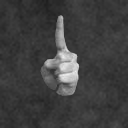

In [7]:
# Verifying single image
Image.open(train_paths[0])

In [8]:
# Verifying dimensions
img = Image.open(train_paths[0])
dimensions = img.size

print(dimensions)

(128, 128)


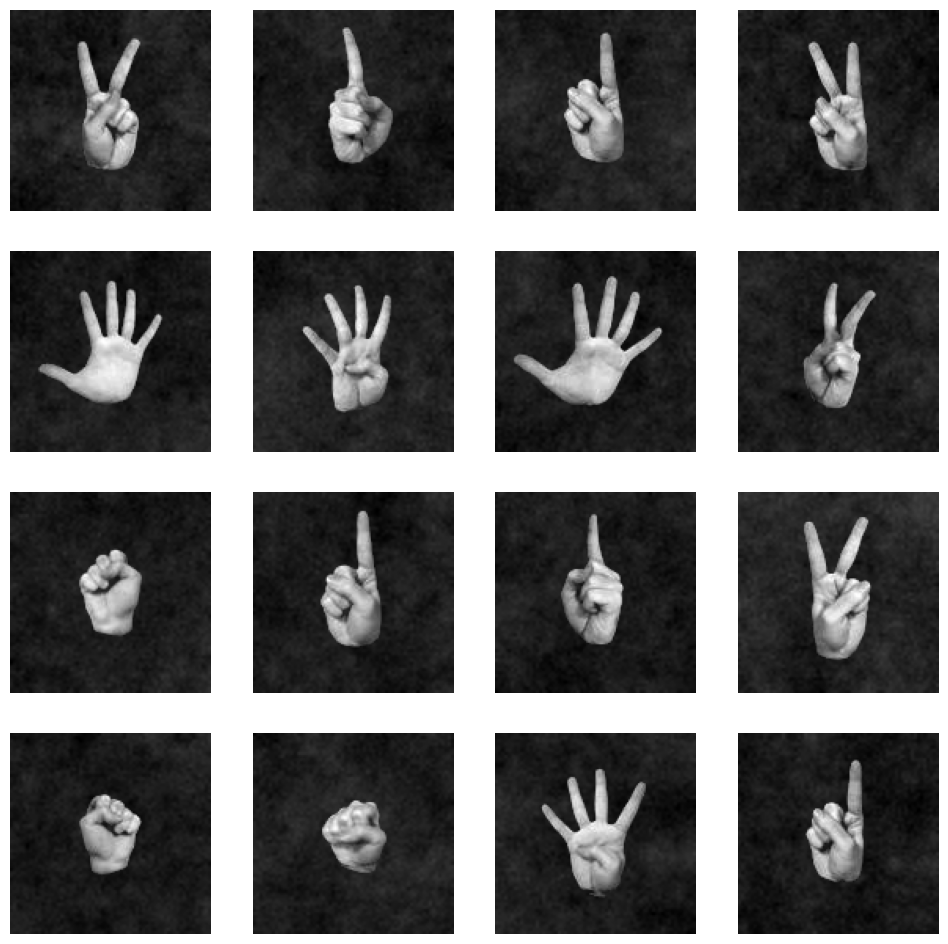

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

# Randomly select 16 training image paths and display them
for i, path in enumerate(random.sample(train_paths, 16)):
    img = Image.open(path)  # open image from random image path
    axes[i].imshow(img, cmap='gray')  # display image in grayscale
    axes[i].axis('off')

In [10]:
# Transformations for training dataset
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Force grayscale to 3 channels, so that it can be fed to ResNet18
    transforms.Resize((227, 227)),               # Resize the image to 227x227 pixels
    transforms.ToTensor(),                       # Convert the image to a PyTorch tensor and normalize pixel values to [0, 1]
])

# Transformations for validation dataset
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Force grayscale to 3 channels, so that it can be fed to ResNet18
    transforms.Resize((227, 227)),               # Resize the image to 227x227 pixels
    transforms.ToTensor(),                       # Convert the image to a PyTorch tensor and normalize pixel values to [0, 1]
])

# Organize the transformations into a dictionary for easy access
transform = {
    'train_transform': train_transform,
    'val_transform': val_transform
}

In [11]:
# There's some information in the path's name that needs to be extracted...
# Notably, the 3L part, which indicates 3 fingers and Left Hand respectively.
print(train_images[0])

b8392e42-30f3-47ee-993f-f55510d74db1_1L.png


In [12]:
class dataset(Dataset):
    def __init__(self, paths, transform=None, is_train=True):
        """
        Initializes the dataset.
        Args:
            paths (list): List of file paths for the images.
            transform (dict): Dictionary containing training and validation transformations.
            is_train (bool): Flag indicating whether the dataset is for training or validation.
        """
        self.paths = paths

        # int(x[-6]) assumes the 6th-to-last character in the filename represents the class.
        # int(x[-5] == 'R') assigns a binary label (0 or 1) based on whether the 5th-to-last character is 'R'.
        self.labels = [(int(x[-6]), int(x[-5] == 'R')) for x in self.paths]

        self.transform = transform
        self.is_train = is_train    # flag to determine which transform to apply

    def __getitem__(self, index):
        """
        Retrieves the image and label at the specified index.
        Args:
            index (int): Index of the data point to retrieve.
        Returns:
            tuple: Transformed image tensor and corresponding label tensor.
        """
        # open image file at index
        img = Image.open(self.paths[index])

        # get the image's label
        label = self.labels[index]

        # convert to tensor of type long... remember that a label is a tuple of 2 int values
        label = torch.tensor(label, dtype=torch.long)

        # apply transformations
        if self.transform:
            if self.is_train:
                img = self.transform["train_transform"](img)
            else:
                img = self.transform["val_transform"](img)

        # ensure the image tensor is of type float32
        img = img.type(torch.float32)

        return img, label

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.paths)

# Defining the model's architecture

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())

cuda
1


In [14]:
# let me see the current architecture
print(resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
class MultiTaskResNet18(nn.Module):
    def __init__(self, num_fingers=6, num_hands=2):
        super().__init__()
        base = resnet18(weights=None)

        # keep all layers except final FC
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features

        self.finger_count = nn.Linear(in_features, num_fingers)
        self.hand_class = nn.Linear(in_features, num_hands)

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)

        finger_out = self.finger_count(x)
        hand_out = self.hand_class(x)

        return finger_out, hand_out

    def initialize_weights(self):
        """
        Applies Kaiming Uniform initialization to all convolutional and linear layers.
        Biases are initialized to zero.
        """
        print("Initializing weights...")
        for m in self.modules():
            # Kaiming Uniform to Conv2d weights
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            # Kaiming Uniform to Linear weights
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [16]:
model = MultiTaskResNet18()
print(model)

MultiTaskResNet18(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

# Training / Validation

In [17]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### This will take a while to run (>5mins)

In [18]:
# set global seed before training
set_seed(433)

model = MultiTaskResNet18().to(device)
model.initialize_weights()

num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize generator for train_loader
g = torch.Generator()
g.manual_seed(433)

# Create the dataset using paths and transformations, and create DataLoader
train = dataset(train_paths, transform)
train_loader = DataLoader(train, batch_size=64, shuffle=True, generator=g)

valid = dataset(val_paths, transform, is_train=False)
valid_loader = DataLoader(valid, batch_size=64, shuffle=False)

test = dataset(test_paths, transform, is_train=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []
batch_train_losses = []
batch_val_losses = []

# Initialize the best validation score to infinity
best_score = float("inf")

# Tolerance counter for early stopping
tolerance = 0

# Training loop
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch+1}/{num_epochs}:")

    epoch_loss = 0
    model.train()

    # Loop through batches of training data
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        finger_count, hand_class = model(images)

        # Compute the loss for each task
        loss_fingers = criterion(finger_count, labels[:, 0])
        loss_hand = criterion(hand_class, labels[:, 1])

        # Combine the losses for the two tasks
        loss = loss_fingers + loss_hand
        epoch_loss += loss
        batch_train_losses.append(loss.item())

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress for every 50th batch
        if i % 50 == 0:
            print(f"  Batch {i+1}/{len(train_loader)}: Current loss = {loss.item():.4f}")

    # Calculate the average training loss for the epoch
    train_loss = epoch_loss / len(train_loader)

    # Evaluate and calculate validation loss
    model.eval()
    val_loss = 0

    with torch.no_grad():
        # Loop through batches of validation data
        for i, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            finger_count, hand_class = model(images)

            # Compute the loss predictions
            loss_fingers = criterion(finger_count, labels[:, 0])  # labels[:,0] contains the true finger count
            loss_hand = criterion(hand_class, labels[:, 1])  # labels[:,1] contains the true hand class

            # Combine the losses for both tasks
            loss = loss_fingers + loss_hand
            batch_val_losses.append(loss.item())

            # Accumulate the loss across all batches
            val_loss += loss

    # Calculate the average validation loss for the epoch
    val_loss = val_loss / len(valid_loader)

    # Register the best validation loss so far
    if val_loss < best_score:
        best_score = val_loss
        print(f"  Average Validation loss improved to {val_loss:.4f}")
    else:
        # Increment tolerance if validation loss does not improve
        tolerance += 1
        print(f"  Average Validation loss did not improve. Tolerance = {tolerance}/5.")

        # Stop training if validation loss has not improved for 5 epochs
        if tolerance == 5:
            print("Early stopping: Validation loss did not improve for 5 consecutive epochs.")
            break

    # Append training and validation losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print statistics
    print(f"Avg Train Loss = {train_loss:.4f}, Avg Val Loss = {val_loss:.4f}")
    print('-' * 80)

Initializing weights...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:
  Batch 1/235: Current loss = 2.9510
  Batch 51/235: Current loss = 0.0246
  Batch 101/235: Current loss = 0.0170
  Batch 151/235: Current loss = 0.0058
  Batch 201/235: Current loss = 0.0008
  Average Validation loss improved to 0.0004
Avg Train Loss = 0.0775, Avg Val Loss = 0.0004
--------------------------------------------------------------------------------
Epoch 2/5:
  Batch 1/235: Current loss = 0.0004
  Batch 51/235: Current loss = 0.0001
  Batch 101/235: Current loss = 0.0169
  Batch 151/235: Current loss = 0.0026
  Batch 201/235: Current loss = 0.1897
  Average Validation loss did not improve. Tolerance = 1/5.
Avg Train Loss = 0.0221, Avg Val Loss = 0.1905
--------------------------------------------------------------------------------
Epoch 3/5:
  Batch 1/235: Current loss = 0.0141
  Batch 51/235: Current loss = 0.0007
  Batch 101/235: Current loss = 0.0005
  Batch 151/235: Current loss = 0.0003
  Batch 201/235: Current loss = 0.0002
  Average Validation loss impr

In [19]:
# Checking the type
print(train_losses[0])
print(val_losses[0])
print(batch_train_losses[0])
print(batch_val_losses[0])

0.07747974246740341
0.00035665780887939036
2.950961112976074
0.0011242583859711885


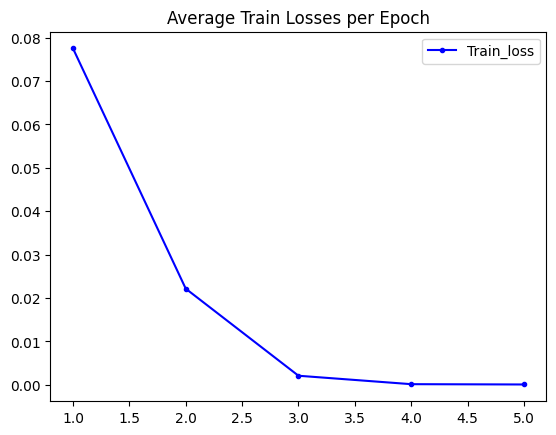

In [20]:
# Plot training (blue) loss over epochs
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, "b-", label="Train_loss", marker='.')
plt.title("Average Train Losses per Epoch")
plt.legend()
plt.show()

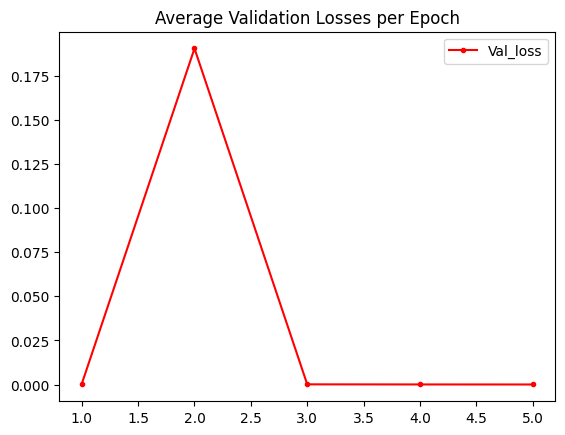

In [21]:
# Plot validation (red) loss over epochs
epochs = range(1, num_epochs + 1)
plt.plot(epochs, val_losses, "r-", label="Val_loss", marker='.')
plt.title("Average Validation Losses per Epoch")
plt.legend()
plt.show()

In [22]:
# sanity check
print(len(train_loader))
print(len(valid_loader))

235
47


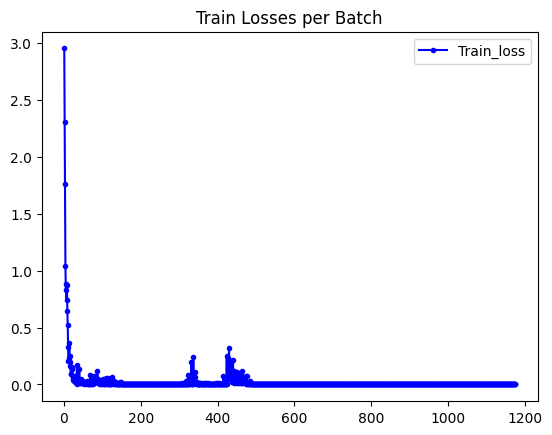

In [23]:
# Plot training (blue) loss over batches
batches = range(1, len(train_loader) * num_epochs + 1)
plt.plot(batches, batch_train_losses, "b-", label="Train_loss", marker='.')
plt.title("Train Losses per Batch")
plt.legend()
plt.show()

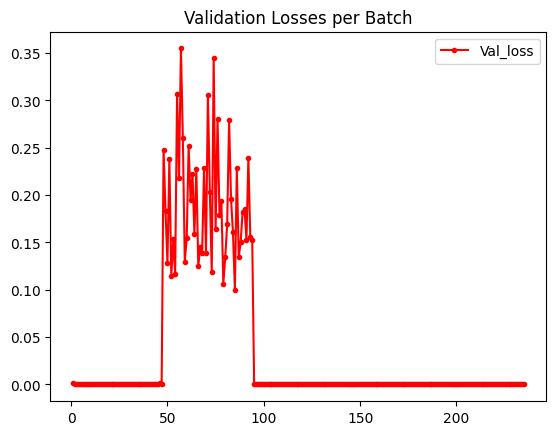

In [24]:
# Plot validation (red) loss over batches
batches = range(1, len(valid_loader) * num_epochs + 1)
plt.plot(batches, batch_val_losses, "r-", label="Val_loss", marker='.')
plt.title("Validation Losses per Batch")
plt.legend()
plt.show()

# Testing

In [25]:
model.eval()

hand_classes = ["Left", "Right"]
num_finger_classes = 6 # fingers go from 0-5, so 6 classes

# Confusion matrices
hand_cm = np.zeros((2, 2), dtype=int)
finger_cm = np.zeros((num_finger_classes, num_finger_classes), dtype=int) # fingers go from 0-5, so 6 classes

# Need this for full metrics
all_hand_preds, all_hand_labels = [], []
all_finger_preds, all_finger_labels = [], []

with torch.no_grad():
    test_loss = 0

    # Loop through batches in the test dataset
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        finger_count, hand_class = model(images)

        # Losses
        loss_fingers = criterion(finger_count, labels[:, 0])
        loss_hand = criterion(hand_class, labels[:, 1])
        loss = loss_fingers + loss_hand
        test_loss += loss

        # Prediction will be the neuron that outputs the highest probability
        finger_preds = torch.argmax(finger_count, dim=1)
        hand_preds = torch.argmax(hand_class, dim=1)

        # Collect all predictions and labels
        all_hand_preds.extend(hand_preds.cpu().numpy())
        all_hand_labels.extend(labels[:, 1].cpu().numpy())
        all_finger_preds.extend(finger_preds.cpu().numpy())
        all_finger_labels.extend(labels[:, 0].cpu().numpy())

        # Update confusion matrices
        hand_cm += confusion_matrix(
            labels[:, 1].cpu().numpy(),
            hand_preds.cpu().numpy(),
            labels=[0, 1]
        )

        finger_cm += confusion_matrix(
            labels[:, 0].cpu().numpy(),
            finger_preds.cpu().numpy(),
            labels=list(range(num_finger_classes))
        )

  0%|          | 0/57 [00:00<?, ?it/s]

# Metrics

In [26]:
"""

    From Confusion Matrix docs (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

    Thus in binary classification, the count of

    true negatives is C_{0,0},
    false negatives is C_{1,0},
    true positives is C_{1,1} and
    false positives is C_{0,1}.

    Binary classification is the case of hand side classification

"""

# TEST LOSS
print("=== TEST RESULTS ===")
print(f"\nAverage Test Loss: {test_loss / len(test_loader)}")


# HAND SIDE
hand_tn, hand_fp, hand_fn, hand_tp = hand_cm.ravel()
print("\n---- HAND SIDE CLASSIFICATION ----")
print(f"\nTP: {hand_tp}, TN: {hand_tn}, FP: {hand_fp}, FN: {hand_fn}")
print("\nConfusion Matrix (rows=true, cols=pred):")
print(hand_cm)

print("\nClassification Report:")
print(classification_report(all_hand_labels, all_hand_preds, target_names=hand_classes, digits=4))


# FINGER COUNT
print("\n--- FINGER COUNT CLASSIFICATION ---")
print("\nConfusion Matrix (rows=true, cols=pred):")
print(finger_cm)

print("\nClassification Report:")
print(classification_report(
    all_finger_labels,
    all_finger_preds,
    labels=list(range(num_finger_classes)),
    target_names=[f"{i}_fingers" for i in range(num_finger_classes)],
    digits=4
))

=== TEST RESULTS ===

Average Test Loss: 2.085659980366472e-05

---- HAND SIDE CLASSIFICATION ----

TP: 1800, TN: 1800, FP: 0, FN: 0

Confusion Matrix (rows=true, cols=pred):
[[1800    0]
 [   0 1800]]

Classification Report:
              precision    recall  f1-score   support

        Left     1.0000    1.0000    1.0000      1800
       Right     1.0000    1.0000    1.0000      1800

    accuracy                         1.0000      3600
   macro avg     1.0000    1.0000    1.0000      3600
weighted avg     1.0000    1.0000    1.0000      3600


--- FINGER COUNT CLASSIFICATION ---

Confusion Matrix (rows=true, cols=pred):
[[600   0   0   0   0   0]
 [  0 600   0   0   0   0]
 [  0   0 600   0   0   0]
 [  0   0   0 600   0   0]
 [  0   0   0   0 600   0]
 [  0   0   0   0   0 600]]

Classification Report:
              precision    recall  f1-score   support

   0_fingers     1.0000    1.0000    1.0000       600
   1_fingers     1.0000    1.0000    1.0000       600
   2_fingers     1